In [1]:
from tqdm import tqdm, trange
import torch
import torchvision
from PIL import Image, ImageDraw
from torchvision import models
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imagesize
from torch.utils import data
import torch.optim as optim
from skimage import io, color
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import os
from pathlib import Path
from torch.utils.data import SubsetRandomSampler,DataLoader,Dataset
import cv2
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
np.random.seed(0)
torch.manual_seed(0)

/home/anshul/.conda/envs/py38torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_path = 'BreakHis/fold1_seperated_2_classes/test/100X/Malignant/SOB_M_DC-14-11520-100-002.png'
img = Image.open(img_path)

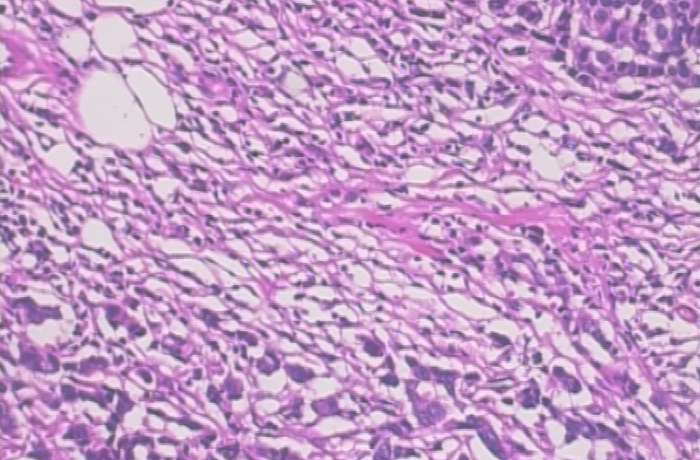

In [3]:
img

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
training_dataset_path = 'BreakHis/combined_dataset/combined_train/'
testing_dataset_path = 'BreakHis/combined_dataset/combined_test/'

In [6]:
def train_transform():
  transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.7900, 0.6163, 0.7614],
                            std = [0.1038, 0.1382, 0.0885])
    ])
  return transform

In [7]:
transform =  train_transform()

In [8]:
X = transform(img).unsqueeze_(0)

In [9]:
def load_dataset(path,transform_img):
  data = torchvision.datasets.ImageFolder(root=path, transform=transform)
  return data

In [10]:
training_dataset = load_dataset(training_dataset_path,transform)
training_dataset

Dataset ImageFolder
    Number of datapoints: 5005
    Root location: BreakHis/combined_dataset/combined_train/
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.79, 0.6163, 0.7614], std=[0.1038, 0.1382, 0.0885])
           )

In [11]:
testing_dataset = load_dataset(testing_dataset_path,transform)
testing_dataset

Dataset ImageFolder
    Number of datapoints: 2904
    Root location: BreakHis/combined_dataset/combined_test/
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.79, 0.6163, 0.7614], std=[0.1038, 0.1382, 0.0885])
           )

In [12]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 16,shuffle=True)

In [13]:
#Splitting Testing Data into 30% Validation and 70% Testing
dataset_size = len(testing_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.3 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
test_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx) 
test_loader = torch.utils.data.DataLoader(dataset = testing_dataset,batch_size = 16,sampler=test_sampler,shuffle=False)
val_loader = DataLoader(dataset= testing_dataset, shuffle=False, batch_size=16, sampler=val_sampler)

In [14]:
from transformers import CvtConfig, CvtModel
from transformers import AutoImageProcessor, CvtForImageClassification
configuration = CvtConfig()
model = CvtForImageClassification(configuration)

In [15]:
model.to(device)

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [16]:
model(X.to(device))

ImageClassifierOutputWithNoAttention(loss=None, logits=tensor([[0.3597, 0.1372]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None)

In [17]:
N_EPOCHS = 150
LR = 0.0001
optimizer = optim.SGD(model.parameters(), lr=LR,momentum=0.9)
criterion = CrossEntropyLoss()

In [18]:
def set_device():
  if torch.cuda.is_available():
    dev = 'cuda:0'
  else:
    dev = 'cpu'
  return torch.device(dev)

In [19]:
def train_nn(model, train_loader, test_loader,criterion,optimizer,n_epochs):
  device = set_device()
  best_acc = 0
  train_losses = []
  train_acc = []
  val_acc = []
  val_losses = []
  model = model.to(device)
  for epoch in range(n_epochs):
    print("Epoch number: %d"%(epoch+1))
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    for data in train_loader:
      images,labels = data
      images = images.to(device) #for faster processing
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad() #Set grad = 0 before back prop
      outputs = model(images)

      _,predicted = torch.max(outputs.logits,1)

      loss = criterion(outputs.logits,labels)
      loss.backward() #Calculate Weight gradients
      optimizer.step() #update weights
      running_loss += loss.item()
      running_correct += (labels==predicted).sum().item()
      
    

    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100.0*running_correct/total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)

    print("  -Training Dataset, Got %d out of %d images correctly (%0.3f%%). Epoch Loss: %0.3f"%(running_correct, total, epoch_acc,epoch_loss))
    test_dataset_acc, test_dataset_loss = evaluate_model(model,test_loader,criterion)
    val_acc.append(test_dataset_acc)
    val_losses.append(test_dataset_loss) 

    if (test_dataset_acc>best_acc):
        best_acc = test_dataset_acc
        save_checkpoint(model,epoch,optimizer,best_acc,train_losses, train_acc, val_losses,val_acc)

  print('Finished Training')
  return model,train_losses,train_acc,val_acc,val_losses

In [20]:
def save_checkpoint(model, epoch, optimizer, best_acc, train_losses, train_acc, val_losses, val_acc):
    state = {
        'epoch': epoch + 1,
        'model': model.state_dict(),
        'best accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_acc': train_acc,
        'val_losses': val_losses,
        'val_acc': val_acc
    }
    torch.save(state, 'Models/cvt_combined.pth')

In [21]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad(): 
          for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0) 

            outputs = model(images)

            _,predicted = torch.max(outputs.logits,1)
            loss = criterion(outputs.logits,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss


In [22]:
'''np.save('max_epoch_timecvtcombined.npy', max_epoch_time)
# Plot the maximum epoch time
plt.bar(['Model'], [max_epoch_time], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Maximum Epoch Time (seconds)')
plt.title('Maximum Epoch Time Taken for the Model')
plt.show()'''

"np.save('max_epoch_timecvtcombined.npy', max_epoch_time)\n# Plot the maximum epoch time\nplt.bar(['Model'], [max_epoch_time], color='skyblue')\nplt.xlabel('Model')\nplt.ylabel('Maximum Epoch Time (seconds)')\nplt.title('Maximum Epoch Time Taken for the Model')\nplt.show()"

In [23]:
#Train the model
#history, train_losses, train_acc, val_acc, val_losses = train_nn(model, train_loader,val_loader, criterion, optimizer ,150)

In [24]:
'''from ptflops import get_model_complexity_info

# Define a function to compute FLOPS
def get_flops(model, input_size):
    flops, params = get_model_complexity_info(model, input_size, as_strings=True, print_per_layer_stat=True)
    print(f"FLOPs: {flops}")
    print(f"Parameters: {params}")

# Define the input size. Here, it's a single image with 3 channels and size 512x512
input_size = (3, 224, 224)

# Compute FLOPS for the ViTForImageClassification model
get_flops(model, input_size)'''

'from ptflops import get_model_complexity_info\n\n# Define a function to compute FLOPS\ndef get_flops(model, input_size):\n    flops, params = get_model_complexity_info(model, input_size, as_strings=True, print_per_layer_stat=True)\n    print(f"FLOPs: {flops}")\n    print(f"Parameters: {params}")\n\n# Define the input size. Here, it\'s a single image with 3 channels and size 512x512\ninput_size = (3, 224, 224)\n\n# Compute FLOPS for the ViTForImageClassification model\nget_flops(model, input_size)'

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [26]:
total_params = count_parameters(model)
print(f"Total number of parameters in the integrated model: {total_params}")

Total number of parameters in the integrated model: 19613250


In [27]:
model_path = 'Models/cvt_combined.pth'
check = torch.load(model_path)

In [28]:
check['best accuracy']

79.56371986222733

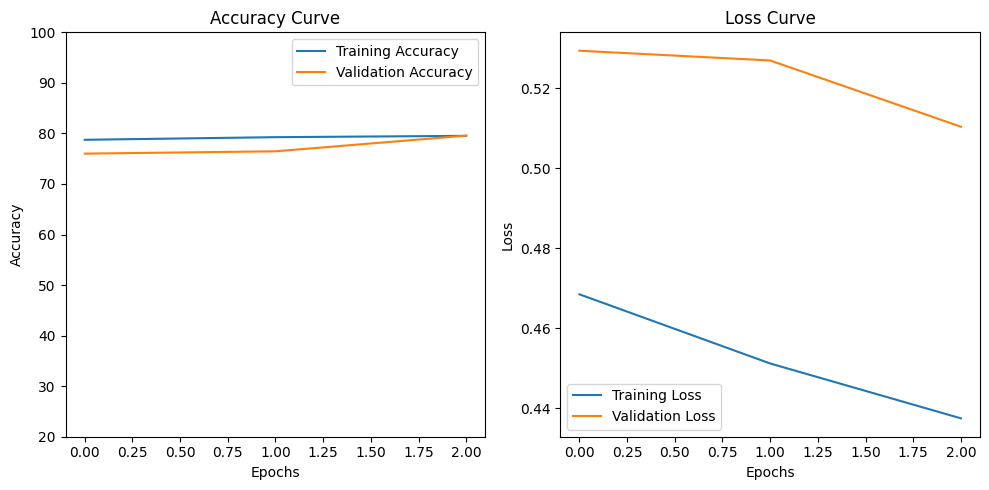

In [29]:
folder_path = 'Graphs/cvt_Combined/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.figure(figsize=(10, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(check['train_acc'], label='Training Accuracy')
plt.plot(check['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.ylim(20, 100)  # Set y-axis limits from 0 to 100 for uniformity
plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy_curve_cvt.png'))

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(check['train_losses'], label='Training Loss')
plt.plot(check['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss_curve_cvt.png'))

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'training_curves_cvt.png'))

plt.show()

In [30]:
model.load_state_dict(check['model'])

<All keys matched successfully>

In [31]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad():
          for data in tqdm(test_loader,desc='Evaluating'):
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _,predicted = torch.max(outputs.logits,1)
            loss = criterion(outputs.logits,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss

In [32]:
#evaluate_model(model,test_loader,criterion)    

In [33]:
#evaluate_model(model,train_loader,criterion)

In [34]:
def evaluate_model_classification_report(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            true_labels.extend(labels.cpu().numpy())

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())

    return true_labels, predicted_labels

In [35]:
#true_labels, predicted_labels = evaluate_model_classification_report(model, test_loader)

In [36]:
from sklearn.metrics import classification_report,roc_auc_score
#print(classification_report(true_labels, predicted_labels))

In [37]:
#auc_score = roc_auc_score(true_labels, predicted_labels)
#print("AUC Score:", auc_score)

Explainability

In [38]:
#model

In [39]:
#model.cvt.encoder.stages[0].layers[0].attention.attention.dropout

In [52]:
img_path = 'CMT/Benign/10X/2.JPG'
img = Image.open(img_path)

In [53]:
img = img.resize((512,512))

In [54]:
model.to(device)

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [55]:
img_path = 'CMT/Benign/40X/2.JPG'
img = Image.open(img_path)
img = img.resize((512,512))
img_tensor = transform(img)
X = transform(img).unsqueeze(0)
#logits = model(img_tensor.to(device))

In [56]:
img_tensor.shape

torch.Size([3, 512, 512])

In [57]:
logits = model(X.to(device))

In [58]:
_,index = torch.max(logits.logits,dim=1)
classes = ['Benign','Malignant']
print(classes[index])

Malignant


In [59]:
model.eval()

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [60]:
#img_tensor = img_tensor.to(device)
#model = model.to(device)

In [61]:
#model = CvtForImageClassification.from_pretrained("microsoft/cvt-13")

Predicted class Malignant: 2.066310405731201


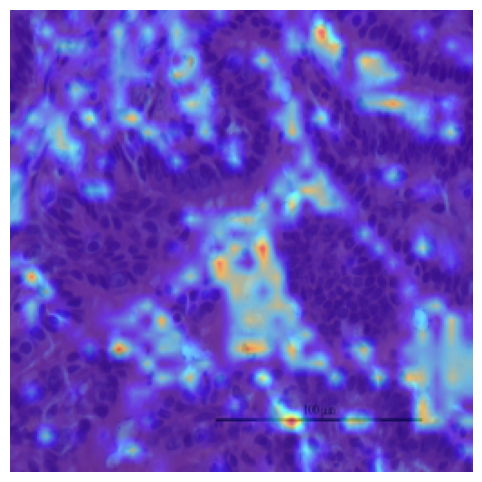

Predicted class Malignant: 2.066310405731201


1

In [70]:
import numpy as np
import cv2
from PIL import Image
from transformers import CvtForImageClassification
from functools import partial
from typing import List, Callable, Optional
import matplotlib.pyplot as plt
from transformers import CvtForImageClassification
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from functools import partial

# Function to print only relevant categories
CATEGORY_NAMES = ["Benign", "Malignant"]
def category_name_to_index(model, category_name):
    return CATEGORY_NAMES.index(category_name)
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]   
    
def print_top_categories(model, img_tensor):
    logits = model(img_tensor.unsqueeze(0)).logits
    benign_index = category_name_to_index(model, "Benign")
    malignant_index = category_name_to_index(model, "Malignant")
    
    relevant_logits = logits[0, [benign_index, malignant_index]]
    max_index = np.argmax(relevant_logits.cpu().detach().numpy())
    category = "Benign" if max_index == 0 else "Malignant"
    max_logit = relevant_logits[max_index].item()
    
    print(f"Predicted class {category}: {max_logit}")
    
    return max_index  # Return the index of the class with the highest probability


# Reshape functions
def reshape_transform_cvt_huggingface(tensor, model, width, height):
    tensor = tensor[:, 1:, :]
    tensor = tensor.reshape(tensor.size(0), height, width, tensor.size(-1))
    norm = model.layernorm(tensor)
    return norm.transpose(2, 3).transpose(1, 2)

def reshape_gradcam_transform_cvt_huggingface(tensor, model, width, height):
    tensor = tensor[:, 1:, :]
    tensor = tensor.reshape(tensor.size(0), height, width, tensor.size(-1))
    return tensor.transpose(2, 3).transpose(1, 2)

#model = CvtForImageClassification.from_pretrained("microsoft/cvt-13")
model = CvtForImageClassification(configuration)
model_path = 'Models/cvt_100X.pth'
check = torch.load(model_path)
model.load_state_dict(check['model'])
model.eval()
reshape_transform = partial(reshape_transform_cvt_huggingface, model=model,
                            width=img_tensor.shape[2] // 16, height=img_tensor.shape[1] // 16)
reshape_transform_gradcam = partial(reshape_gradcam_transform_cvt_huggingface, model=model,
                                     width=img_tensor.shape[2] // 16, height=img_tensor.shape[1] // 16)

targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Malignant")),
                       ClassifierOutputTarget(category_name_to_index(model, "Benign"))]

target_layer_dff = model.cvt.encoder.stages[-1].layers[-1]
target_layer_gradcam = model.cvt.encoder.stages[-1].layers[-2]

class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.Tensor=img_tensor,
                          input_image: Image=img,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:
        
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)
        batch_results = cam(input_tensor=repeated_tensor, targets=targets_for_gradcam)
        
        results = []
        for i, grayscale_cam in enumerate(batch_results):
            category_name = "Benign" if i == 0 else "Malignant"
            visualization = show_cam_on_image(np.float32(input_image) / 255, grayscale_cam, use_rgb=True)
            visualization = cv2.resize(visualization, (visualization.shape[1] // 2, visualization.shape[0] // 2))
            # Add the category name to the image
            #cv2.putText(visualization, category_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            results.append(visualization)
        return np.hstack(results)

# Displaying images and running the model




top_category_index = print_top_categories(model, img_tensor)

# Set the target for Grad-CAM to the class with the highest probability
target_for_gradcam = ClassifierOutputTarget(top_category_index)

# Run Grad-CAM on the top predicted class
grad_cam_result = run_grad_cam_on_image(
    model=model,
    target_layer=target_layer_gradcam,
    targets_for_gradcam=[target_for_gradcam],
    reshape_transform=reshape_transform_gradcam
)


# Display the Grad-CAM result
plt.figure(figsize=(12, 6))
plt.imshow(grad_cam_result)
plt.axis('off')  # Turn off axis labels
plt.show()

# Print only the relevant predictions
print_top_categories(model, img_tensor)



In [68]:
# Convert Grad-CAM result to BGR format for OpenCV
gradcamm = cv2.cvtColor(grad_cam_result, cv2.COLOR_RGB2BGR)

# Display the Grad-CAM image with a specified window name
cv2.imshow("Gradcam", gradcamm)  # Correct usage of cv2.imshow

# Wait for 10 seconds (10000 milliseconds) before automatically closing the window
cv2.waitKey(10000)

# Close all OpenCV windows
cv2.destroyAllWindows()

In [63]:
output_path = 'grad_cam_result.png'  # Specify path to save
cv2.imwrite(output_path, cv2.cvtColor(grad_cam_result, cv2.COLOR_RGB2BGR))  
print(f"Grad-CAM result saved to {output_path}")

Grad-CAM result saved to grad_cam_result.png
